Limpeza de Dados & EDA como objetivo de coompreender o comportamento dos dados para isso faremos:

* Tratamento de valores ausentes
* Remoção de duplicatas
* Análise exploratória univariada e bivariada
* Correlação entre variáveis
* Identificação de padrões associados à fraude



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

### Descrição das Variáveis

| Variável     | Descrição                                                                                                  |
| ------------ | ---------------------------------------------------------------------------------------------------------- |
| `Time`       | Tempo em segundos desde a primeira transação registrada no dataset. Usado para capturar padrões temporais. |
| `V1` a `V28` | Componentes principais obtidas via PCA para anonimização e redução de dimensionalidade.                    |
| `Amount`     | Valor monetário da transação. Única variável não transformada por PCA.                                     |
| `Class`      | Variável alvo: `0` = transação legítima, `1` = fraude.                                                     |

---

In [2]:
df = pd.read_csv('creditcard.csv')

print(df.shape)
df.head(5)

(144667, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


### REMOÇÃO DE DUPLICATAS

---
Evita viés estatístico e métricas infladas


In [3]:
duplicados = df.duplicated().sum()
print(f'Duplicatas encontradas: {duplicados}')

if duplicados > 0:
    df = df.drop_duplicates()

print(f'Novo shape após remoção: {df.shape}')

Duplicatas encontradas: 547
Novo shape após remoção: (144120, 31)


### TRATAMENTO DE VALORES AUSENTES

---
Identificação por tipo de variável


In [4]:
missing = df.isna().mean().sort_values(ascending=False)
missing[missing > 0]

,0
V24,0.000007
V25,0.000007
V26,0.000007
V27,0.000007
V28,0.000007
Amount,0.000007
Class,0.000007
V23,0.000007


# Variáveis numéricas → **mediana** (robusta a outliers)
# Variáveis categóricas → **moda**
# Variáveis com excesso de missing → avaliação para remoção futura

In [5]:
num_cols = df.select_dtypes(include=np.number).columns
cat_cols = df.select_dtypes(include='object').columns

for col in num_cols:
    if df[col].isna().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

for col in cat_cols:
    if df[col].isna().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)

/tmp/ipython-input-1282368767.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


### VARIÁVEL ALVO

---
Forte desbalanceamento ,impacto direto na modelagem.


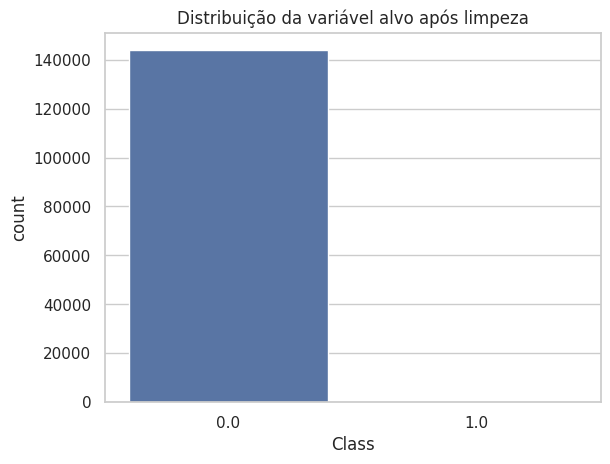

In [6]:
df['Class'].value_counts(normalize=True)

sns.countplot(x='Class', data=df)
plt.title('Distribuição da variável alvo após limpeza')
plt.show()

### VARIÁVEIS NUMERICAS

---
Observado assimetria forte em algumas variáveis o que indica necessidade futura de transformações log / scaling


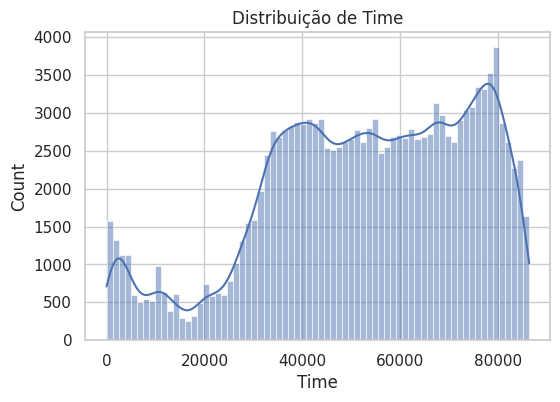

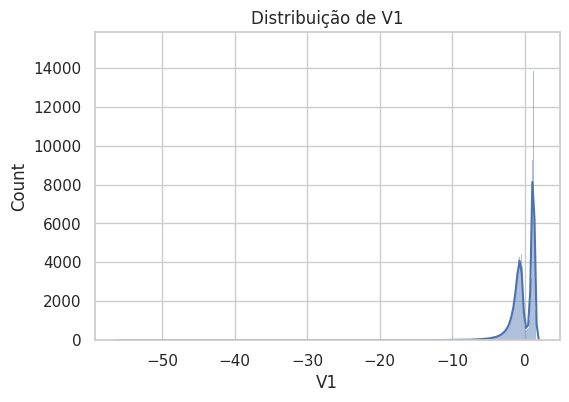

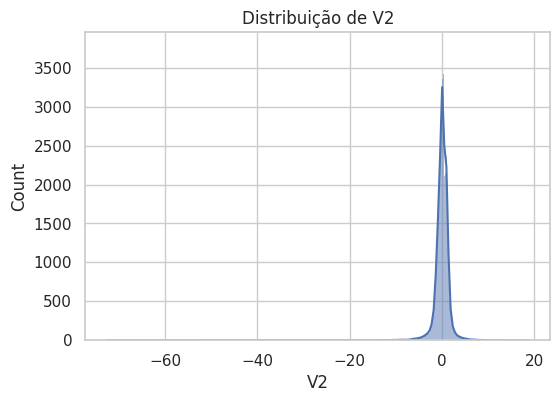

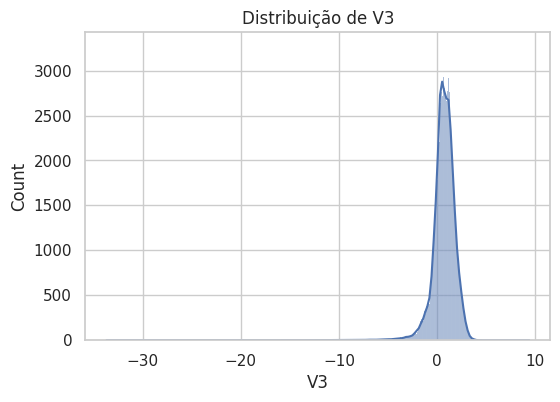

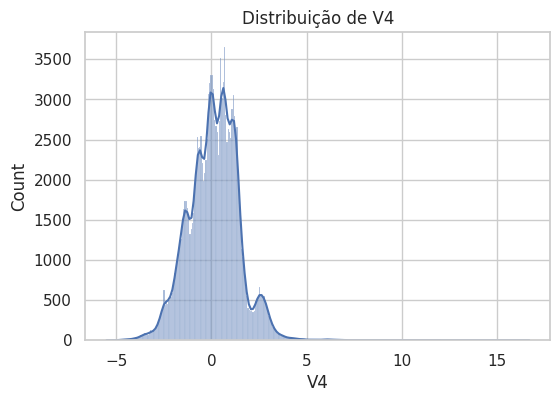

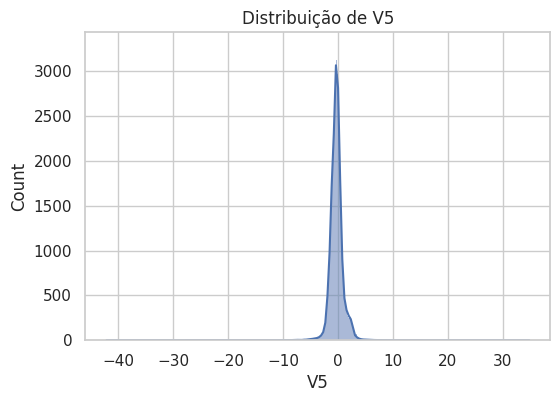

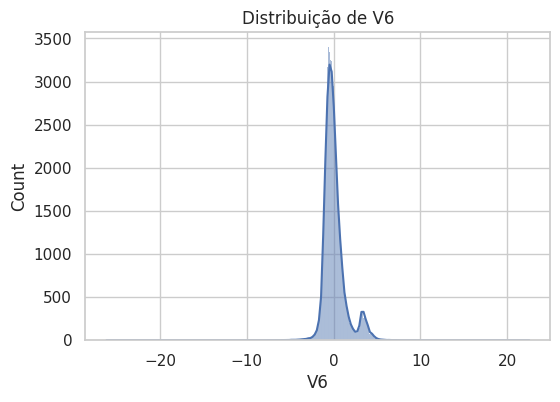

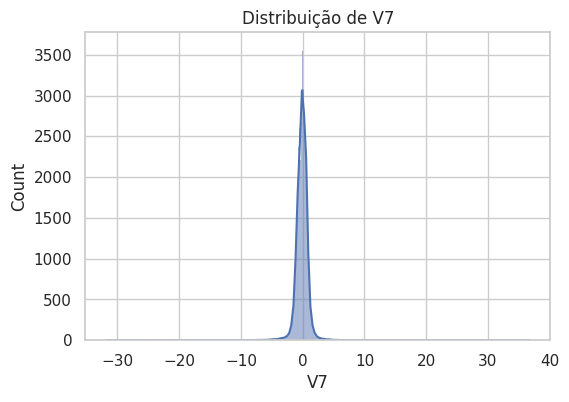

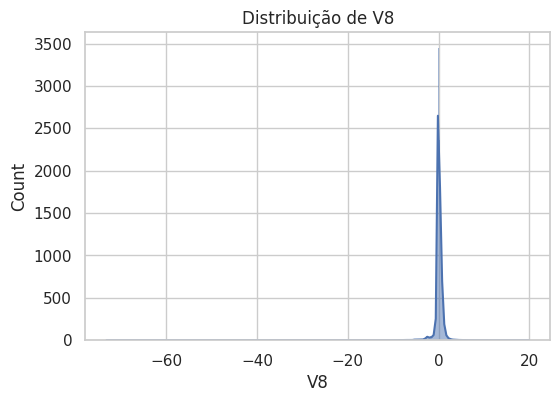

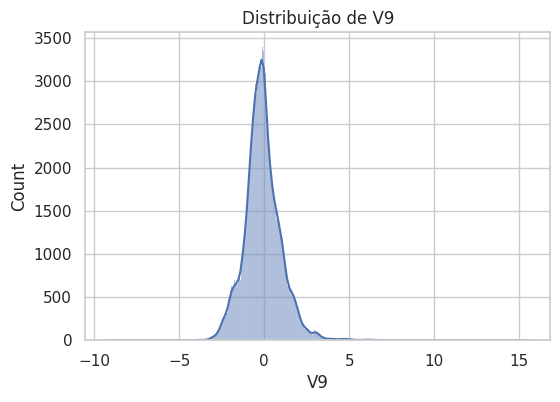

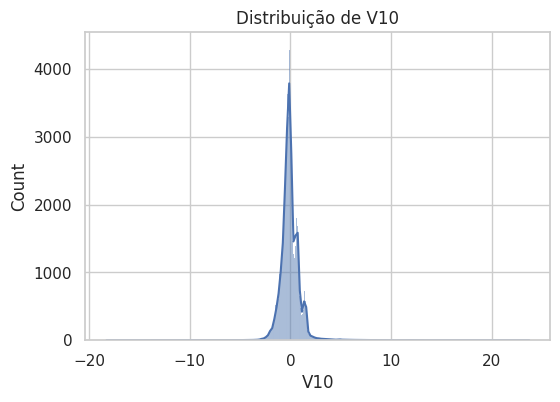

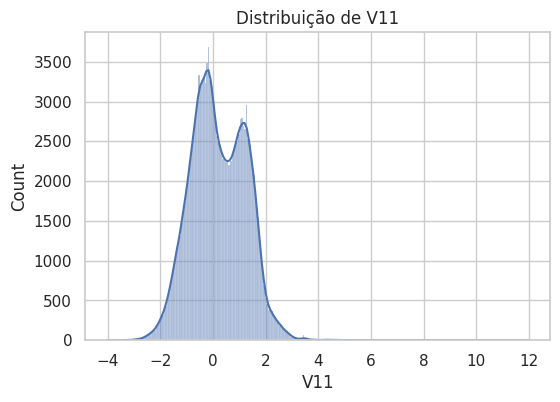

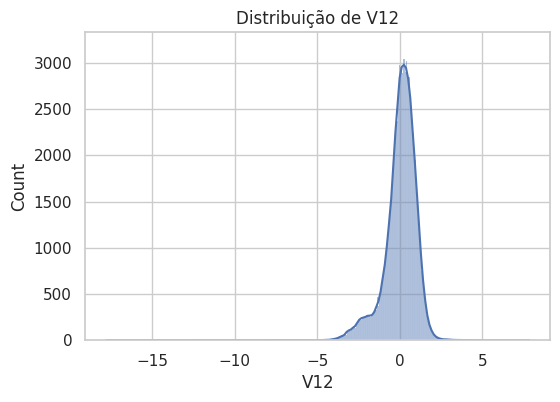

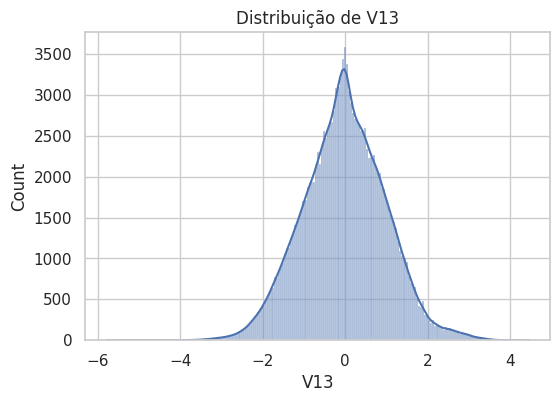

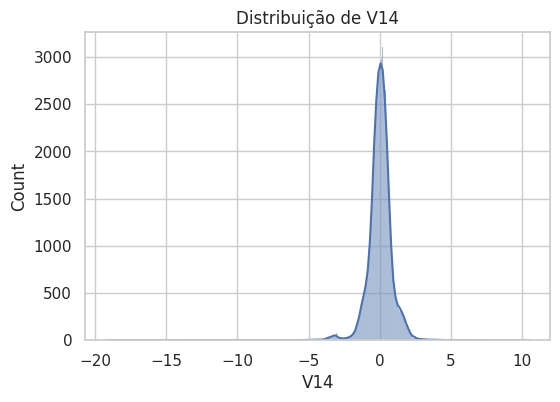

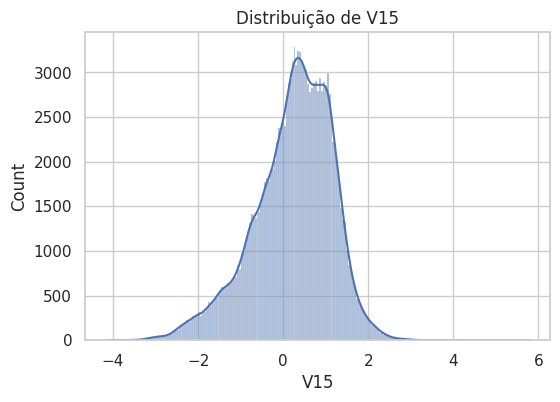

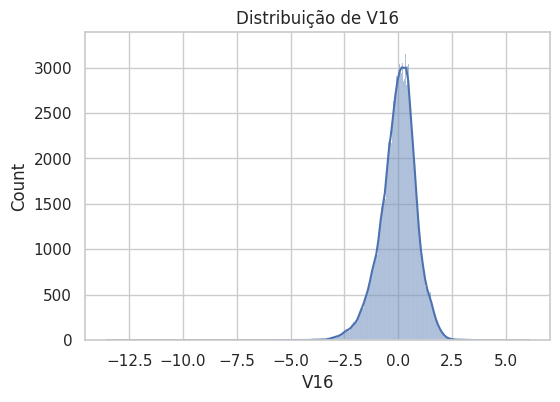

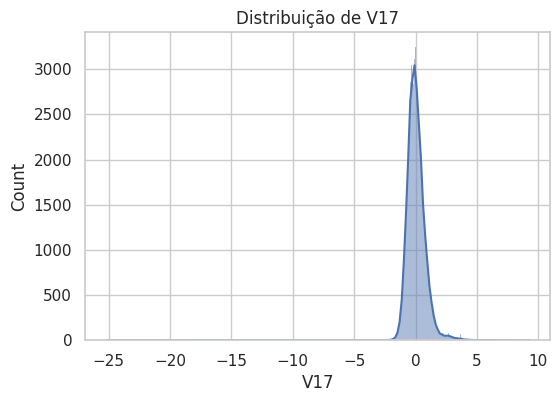

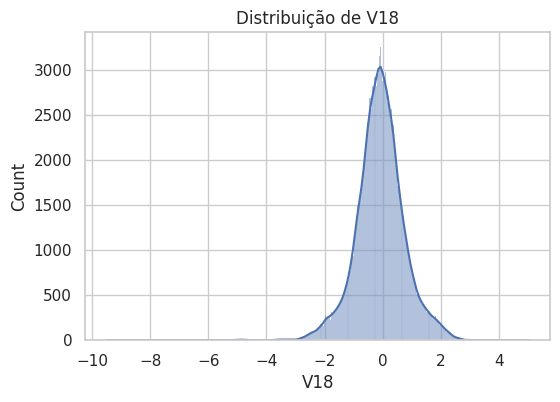

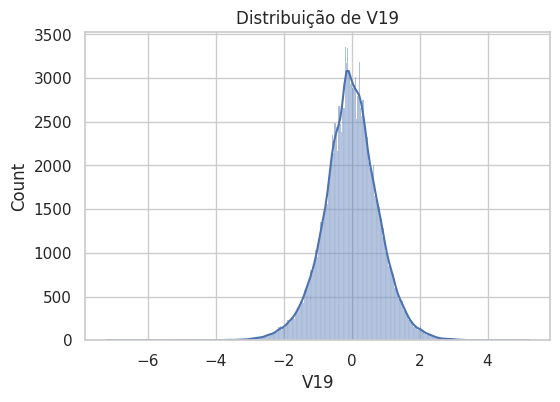

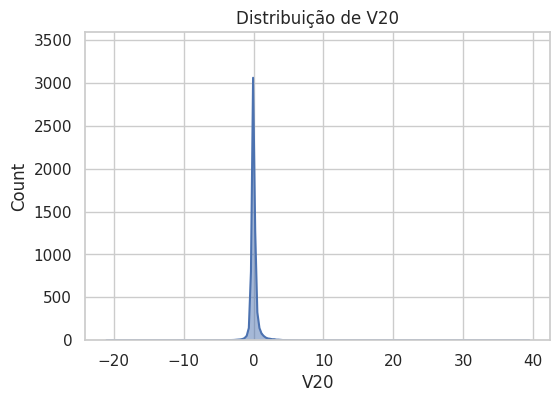

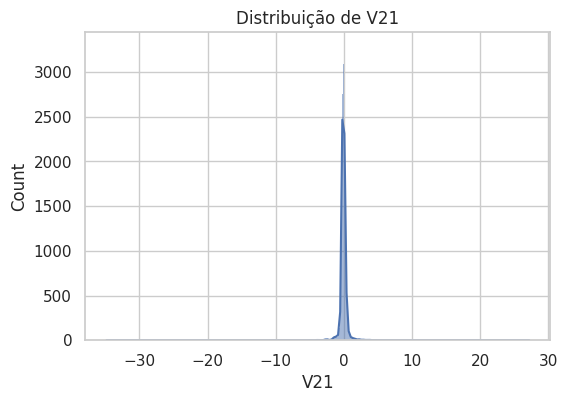

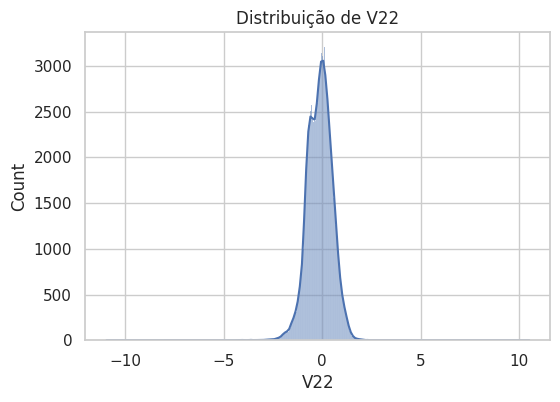

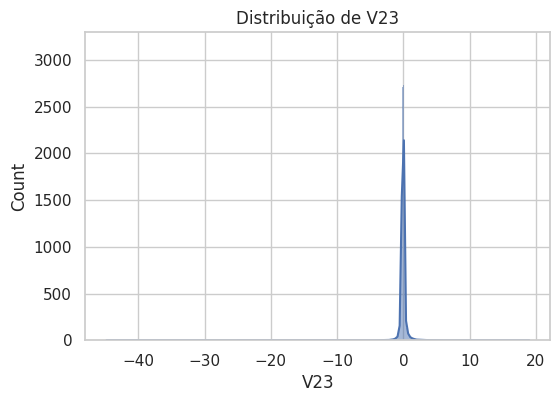

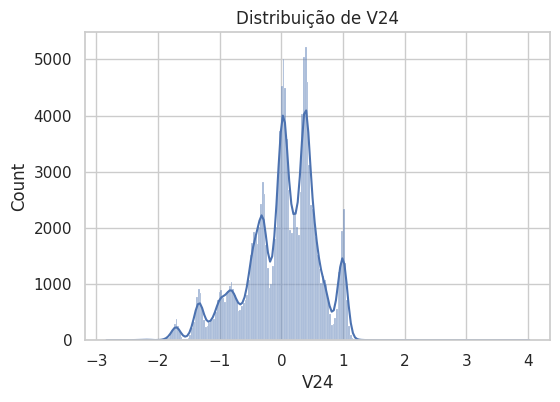

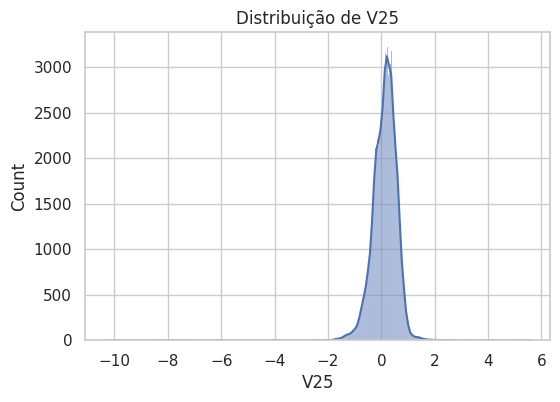

KeyboardInterrupt: 

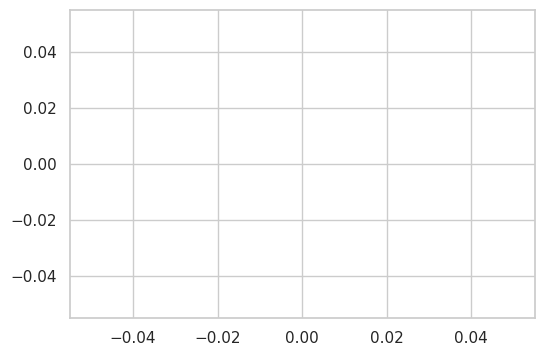

In [7]:
num_cols = df.select_dtypes(include=np.number).columns

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribuição de {col}')
    plt.show()

### Análise bivariada – Variáveis × Fraude

---



In [8]:
num_cols = df.select_dtypes(include=np.number).columns

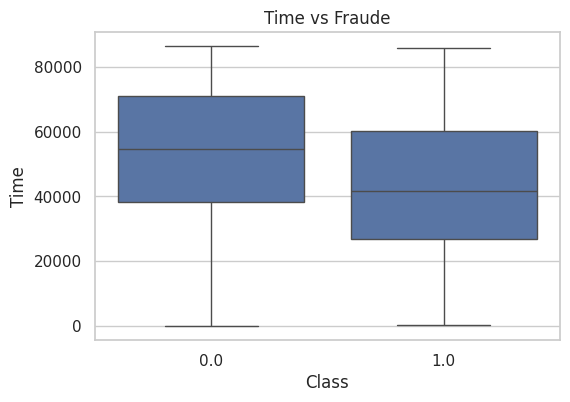

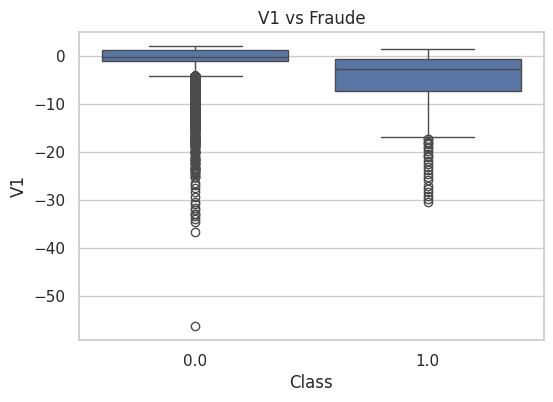

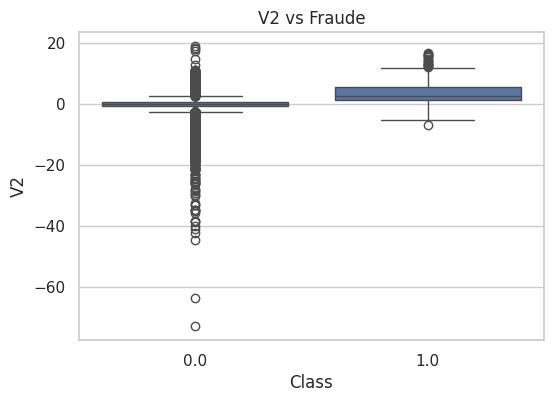

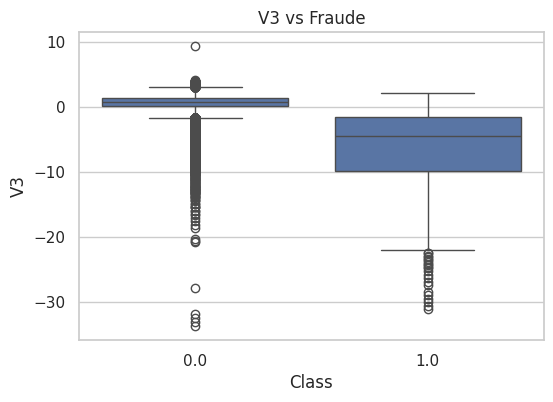

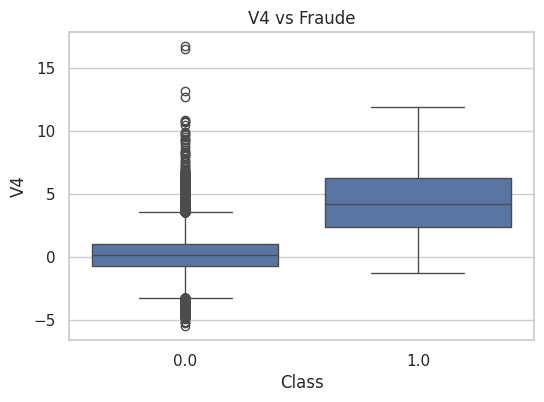

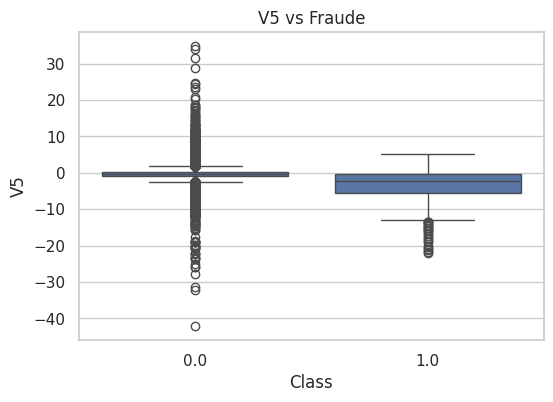

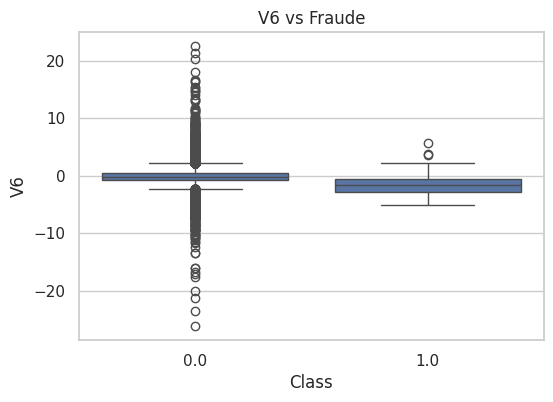

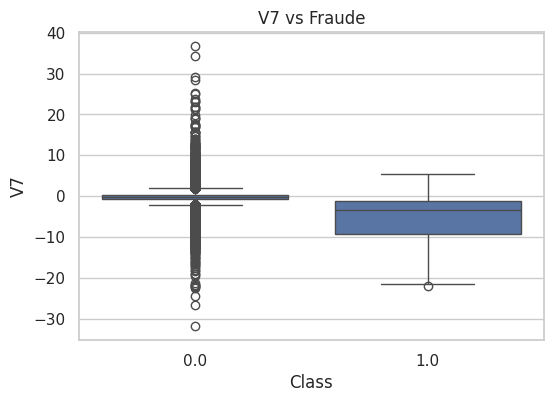

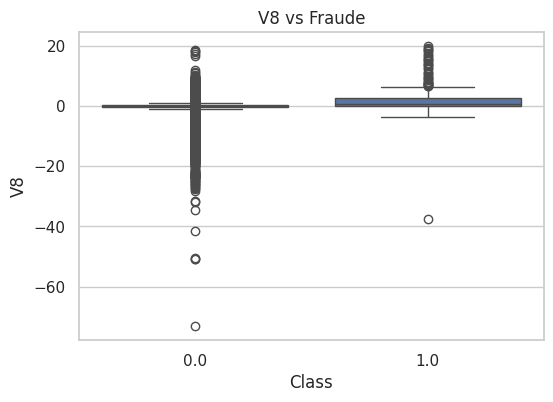

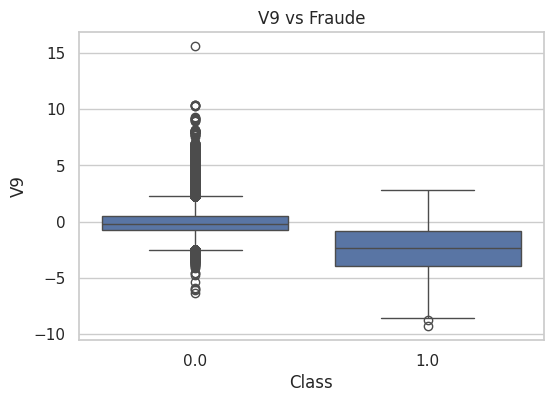

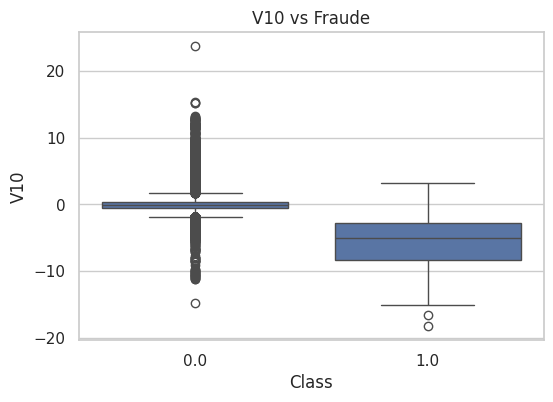

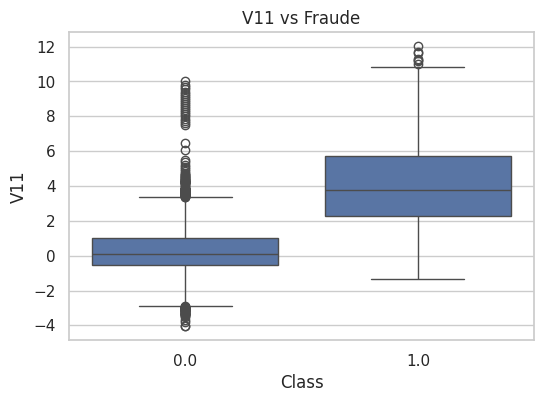

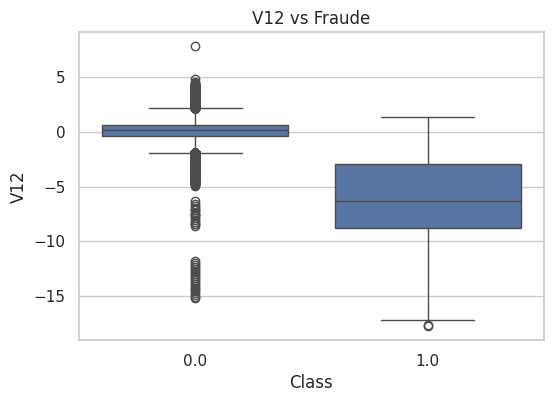

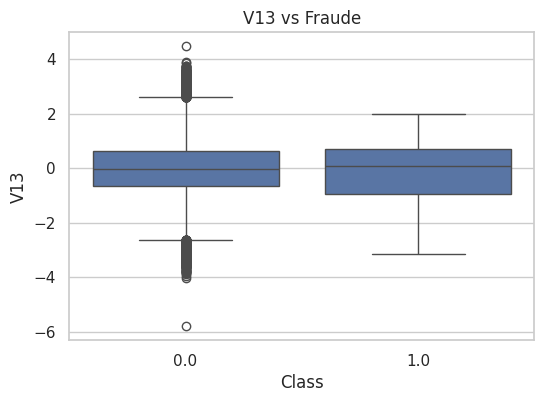

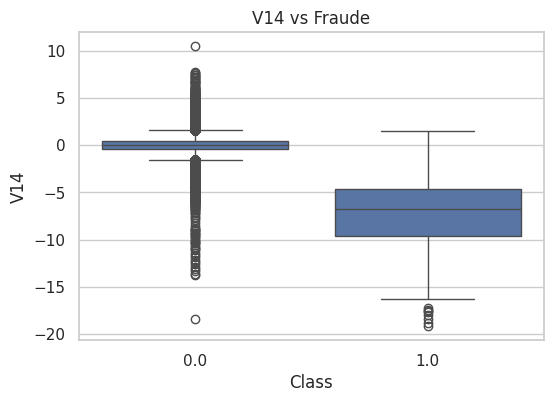

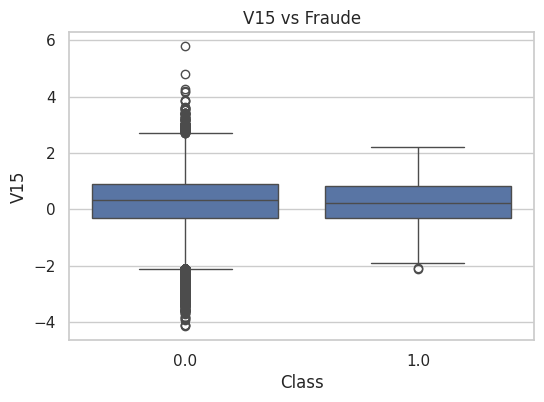

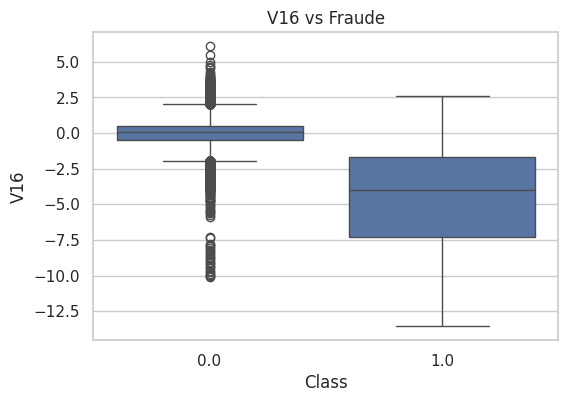

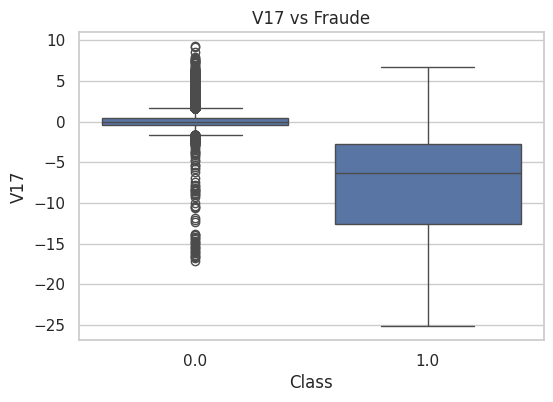

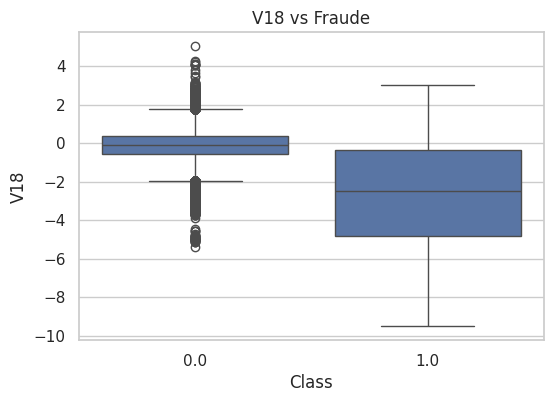

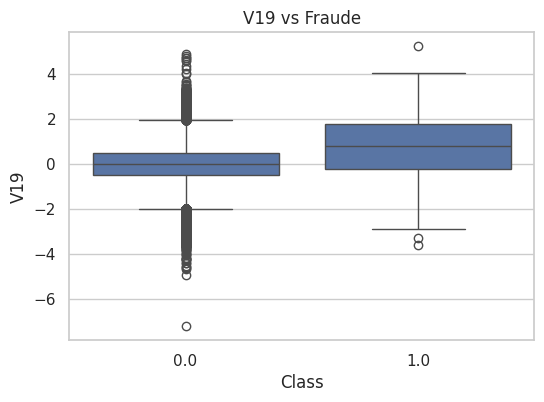

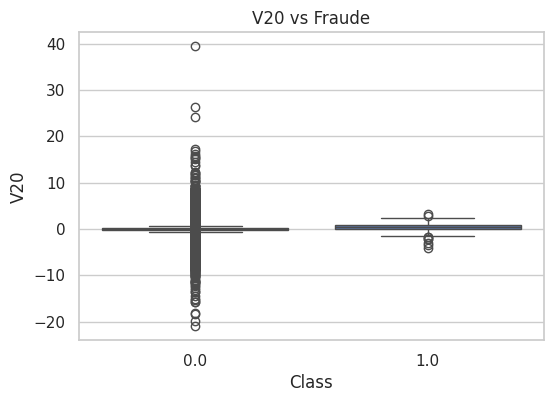

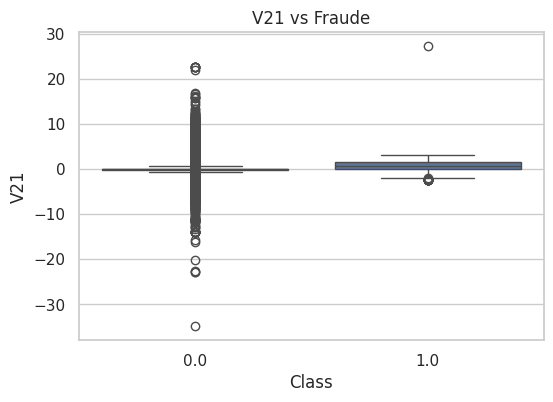

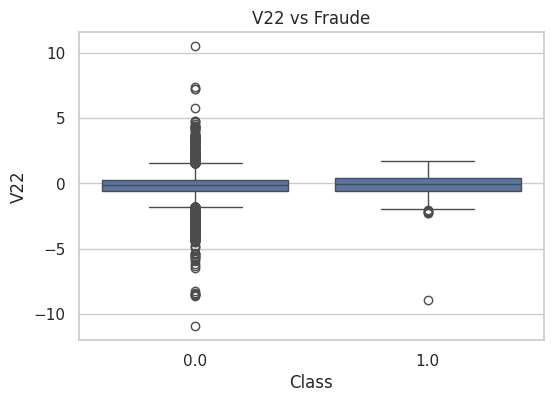

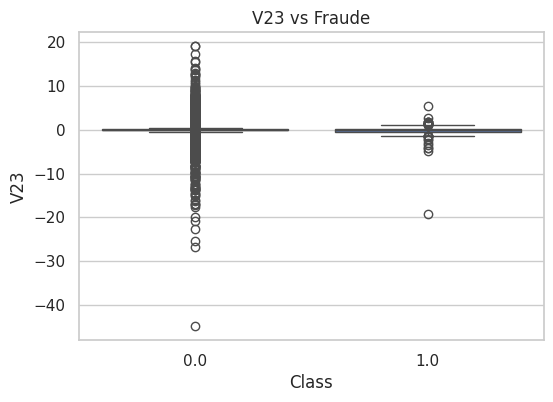

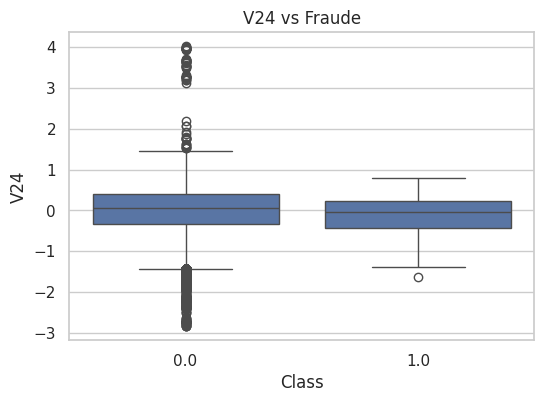

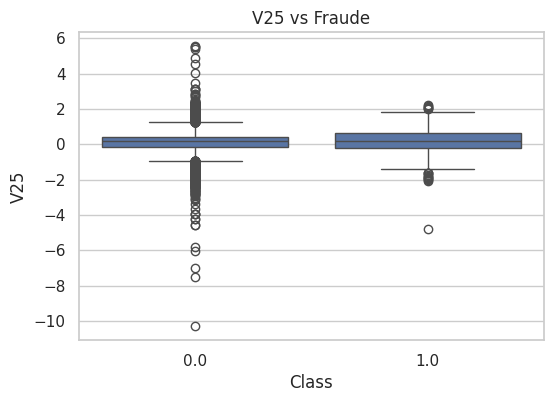

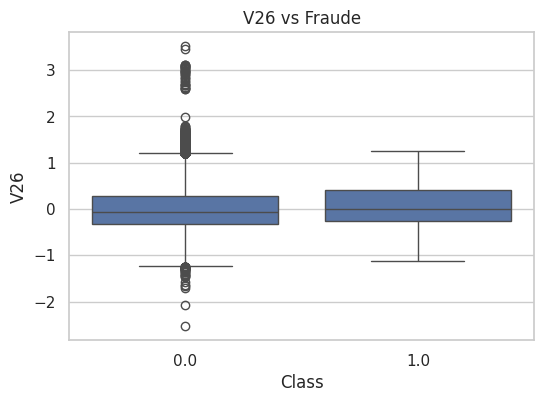

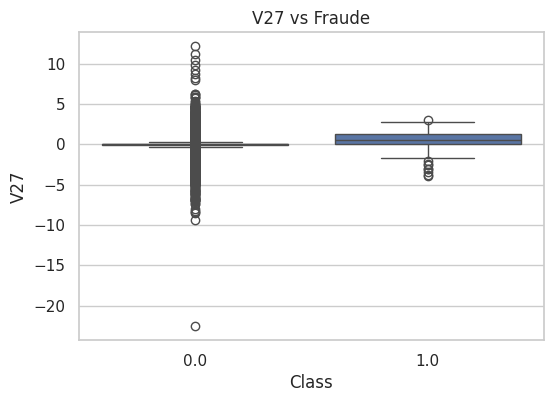

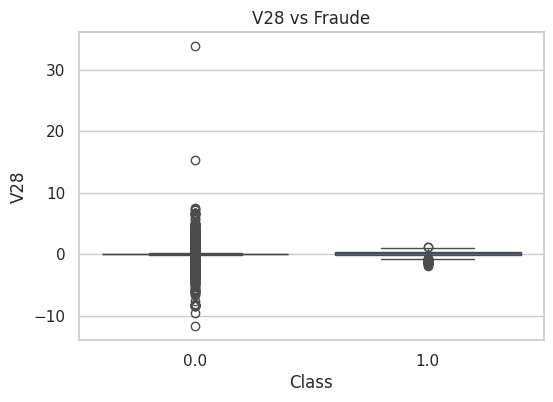

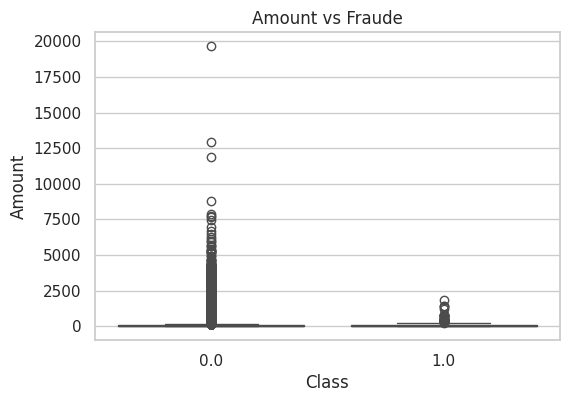

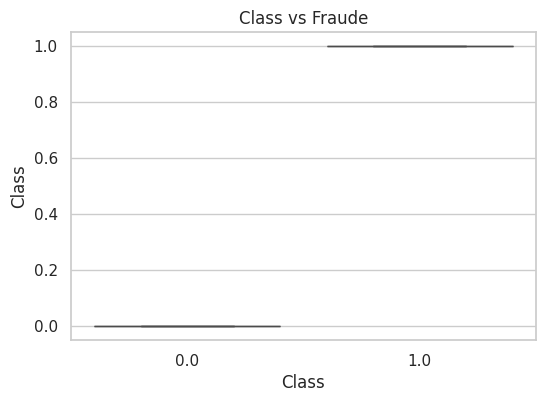

In [10]:
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Class', y=col, data=df)
    plt.title(f'{col} vs Fraude')
    plt.show()

Analisando gráficamente a variável V1 observa-se uma diferença significativa na distribuição entre transações legítimas e fraudulentas, com deslocamento da mediana e maior dispersão nos casos de fraude , ou seja,  V1 contribui para a separação das classes e é relevante para a modelagem preditiva.
Inportante observar cada variavel separadamente e o quanto ela contribui para a predição da variável alvo.

In [11]:
for col in cat_cols:
    plt.figure(figsize=(8,4))
    df.groupby(col)['fraude'].mean().sort_values(ascending=False).plot(kind='bar')
    plt.title(f'Taxa de fraude por {col}')
    plt.ylabel('Proporção de fraude')
    plt.show()

### CORRELAÇÃO

---

Correlações muito altas sugerindo redundância , possível redução de dimensionalidade no próximo notebook

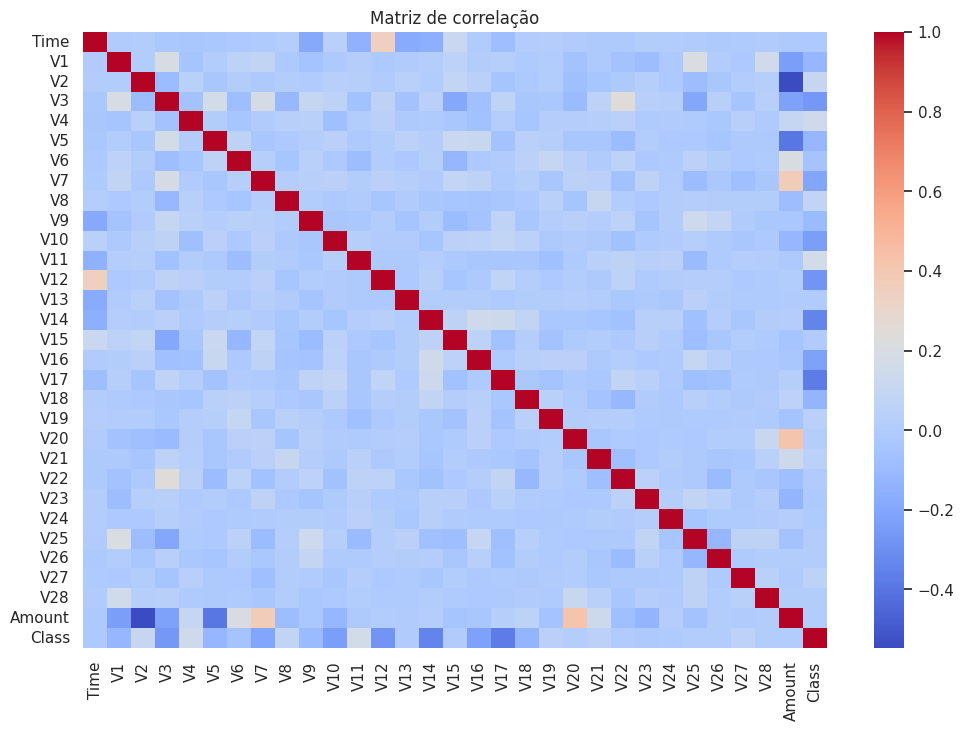

In [12]:
plt.figure(figsize=(12,8))
sns.heatmap(df[num_cols].corr(), cmap='coolwarm', annot=False)
plt.title('Matriz de correlação')
plt.show()

In [13]:
df.to_csv('dados_fraude_limpos.csv', index=False)#salva a base limpa